In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks

learning_rate = 1e-4
training_iterations = 2500

dropout = 0.5
batch_size = 50
validation_size = 2000

Image_to_display = 10


2024-01-25 20:40:39.001530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataload

In [5]:
data = pd.read_csv('/home/s5613008/Final_project/data/fashion-mnist_train.csv')
print('data{0[0]},{0[1]}'.format(data.shape))
print (data.head())

data60000,785
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0     

Data preprocessing

In [6]:
images = data.iloc[:,1:].values
images = images.astype(float)

images = np.multiply(images, 1.0 / 255.0)

image_width = 28
image_height = 28

#print('images{0[0]},{0[1]}'.format(images.shape))

labels = data['label'].values
labels_one_hot = to_categorical(labels)
labels_count = 10

Divide training set and validation set

In [7]:
train_images, validation_images, train_labels, validation_labels = train_test_split(images, labels_one_hot, test_size=validation_size, random_state=42)

Reshape data

In [8]:
train_images = train_images.reshape((-1, 28, 28, 1))
validation_images = validation_images.reshape((-1, 28, 28, 1))

In [9]:
print('shape of train：({}, {})'.format(train_images.shape[0], train_images.shape[1]))
print('shape of validation：({}, {})'.format(validation_images.shape[0], validation_images.shape[1]))

shape of train：(58000, 28)
shape of validation：(2000, 28)


Visualize an image

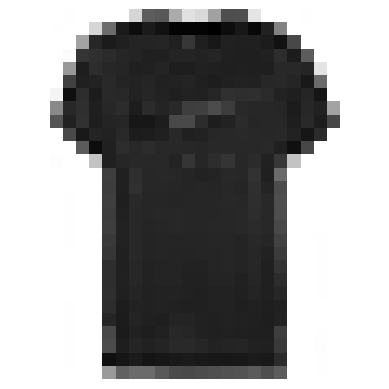

In [10]:
def display(img):
    one_size = img.reshape(image_width, image_height)

    plt.axis('off')
    plt.imshow(one_size, cmap=cm.binary)

display(images[Image_to_display])


Define a Conv2D layer

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models


class MyConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(MyConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

    def build(self, input_shape):
        input_channels = input_shape[-1]
        
        self.kernel = self.add_weight("kernel", shape=(self.kernel_size, self.kernel_size, input_channels, self.filters))
        self.bias = self.add_weight("bias", shape=(self.filters,))
        super(MyConv2D, self).build(input_shape)

    def call(self, inputs):
        conv_output = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME') + self.bias
        return tf.nn.relu(conv_output)


model = models.Sequential()


model.add(layers.InputLayer(input_shape=(28, 28, 1)))
model.add(MyConv2D(filters=32, kernel_size=5))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(MyConv2D(filters=64, kernel_size=5))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=labels_count, activation='softmax'))

2024-01-25 20:41:28.217233: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Set learning rate 

In [13]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Set early stopping

In [14]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='/home/s5613008/Final_project/model_checkpoint',
    monitor='val_accuracy',
    save_best_only=True
)
tensorboard_callback = callbacks.TensorBoard(log_dir='/home/s5613008/Final_project/logs', histogram_freq=1)

In [15]:
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Train model

In [16]:
num_epochs = 10
batch_size = 32
history = model.fit(
    train_images, train_labels, 
    epochs=num_epochs, batch_size=batch_size, 
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback],
    verbose=0 
)
print(history.history['loss']) 
print(history.history['accuracy']) 
print(history.history['val_loss'])  
print(history.history['val_accuracy']) 

2024-01-25 20:42:11.097867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:42:11.192074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:42:39.179361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:42:39.261089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:43:06.980958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:43:07.062550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:43:35.318503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:43:35.399480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:44:03.923979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:44:04.007151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:44:32.439521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:44:32.521825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:45:00.981522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:45:01.064318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:45:29.378926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:45:29.460194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets
2024-01-25 20:46:24.898645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-25 20:46:24.982658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


INFO:tensorflow:Assets written to: /home/s5613008/Final_project/model_checkpoint/assets


[0.6238824129104614, 0.4034978449344635, 0.35418254137039185, 0.32372191548347473, 0.30288711190223694, 0.2863200902938843, 0.2755577564239502, 0.26645010709762573, 0.2595371901988983, 0.2523469030857086]
[0.7738792896270752, 0.8537068963050842, 0.8713620901107788, 0.8819137811660767, 0.8909655213356018, 0.8961896300315857, 0.900672435760498, 0.9042068719863892, 0.9057758450508118, 0.9093965291976929]
[0.41210004687309265, 0.3443351089954376, 0.30967825651168823, 0.2986469864845276, 0.28022998571395874, 0.27056246995925903, 0.26468271017074585, 0.25632792711257935, 0.2551692724227905, 0.25125598907470703]
[0.8519999980926514, 0.8799999952316284, 0.8889999985694885, 0.8955000042915344, 0.9010000228881836, 0.906000018119812, 0.9075000286102295, 0.9085000157356262, 0.9085000157356262, 0.9104999899864197]


Model prediction results

1/1 [==============================] - 0s 53ms/step


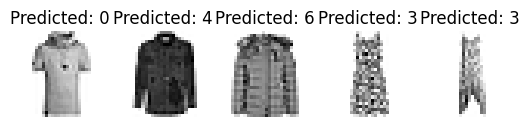

In [17]:
import numpy as np


random_indices = np.random.choice(validation_images.shape[0], size=5, replace=False)
sample_images = validation_images[random_indices]

predictions = model.predict(sample_images)

for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i+1)
    plt.imshow(sample_images[i].reshape(image_width, image_height), cmap=cm.binary)
    plt.title(f"Predicted: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()